# Машинное обучение, DS-поток
## Задание ML.7


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 30 баллов;

In [10]:
# Bot check

# HW_ID: ds_ml7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.base import clone
from IPython.display import clear_output
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix

import catboost as cb
from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from tqdm import tqdm

import itertools

from sklearn.preprocessing import LabelEncoder
from category_encoders import MEstimateEncoder 

sns.set(font_scale=1.3, palette='Set2')

---

### Задача 1

Рассмотрим данные из задачи ML.6.2. Задача заключается в сравнении моделей градиентного бустинга из sklearn, для которой категориальные признаки закодированы с помощью
* LabelEncoding,
* MeanEncoding.

Какие признаки будете рассматривать? Какие именно преобразования будете совершать?

Выкинем признак id - он ничего не дает, просто ключ в таблице

Вместо даты будем писать отдельно год, месяц и день; месяц и день - новые категориальные признаки

Убедимся, что в данных нет пропусков

Категориальные признаки (waterfront, view, condition, grade, zipcode, month, day) будем кодировать с помощью LabelEncoding или MeanEncoding и сравнивать что из этого лучше

Можно посмотреть на координаты, повернем их на 45 и добавим как дополнительный признак

Выполните базовую предобработку данных из задачи ML.6.2

*Совет.* Используйте код из своего решения предыдущего домашнего задания и/или код с семинаров.

Скачаем данные, добавим новый признак через поворот осей

In [12]:
data = pd.read_csv('houses_train.csv')

data = data.drop(['id'], axis=1)

longitudes = data['long']
latitudes = data['lat']

theta = np.radians(45)

data['rotated_lat'] = (latitudes * np.cos(theta) - longitudes * np.sin(theta))
data['rotated_long'] = (latitudes * np.sin(theta) + longitudes * np.cos(theta))

Теперь отредактируем дату

In [13]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%dT%H%M%S')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data.drop(['date'], axis=1, inplace=True)

Разделим на тестовую и тренировочную выборки

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1, inplace=False), 
    data['price'], test_size=0.2, 
    shuffle=True, random_state=17
)

Выполните обработку категориальных признаков

Сначала LabelEncoding

In [15]:
categ = ['waterfront', 'view', 'condition',
         'grade', 'zipcode', 'month', 'day']
numeric = [col for col in X_train.columns if col not in categ ]

label_encoders = {col: LabelEncoder() for col in categ}

X_categ_train_labeled = X_train[categ].apply(lambda col: 
                                         label_encoders[col.name].fit_transform(col))

X_categ_test_labeled = X_test[categ].apply(lambda col: 
                                       label_encoders[col.name].transform(col))

X_train_labeled = pd.concat([X_train[numeric], X_categ_train_labeled], axis=1)
X_test_labeled = pd.concat([X_test[numeric], X_categ_test_labeled], axis=1)

Теперь MeanEncoding

In [16]:
m_estimate_encoder = MEstimateEncoder(cols=categ)
train_categ_meaned = m_estimate_encoder.fit_transform(X_train[categ],
                                                      y_train)

test_categ_meaned = m_estimate_encoder.transform(X_test[categ])

X_train_meaned = pd.concat([X_train[numeric], train_categ_meaned], axis=1)
X_test_meaned = pd.concat([X_test[numeric], test_categ_meaned], axis=1)

Обучите модели и постройте зависимость значения MAPE от количества деревьев и их максимальной глубины.

Функции для построения графиков

In [20]:
def plot_dependence_test(param_grid, test_values_list, param_label,
                         metrics_label, title, model_names,
                         ylim=(None, None), log_scale=False, linestyles=None):
    '''
    Функция для построения графиков зависимости метрики от параметра 
    для нескольких моделей на одном графике.

    Параметры:
    1) param_grid — значения исследуемого параметра,
    2) test_values_list — список списков метрик для каждой модели,
    3) param_label — название параметра,
    4) metrics_label — название метрики,
    5) title — заголовок для графика,
    6) model_names — список названий моделей для легенды,
    7) ylim — ограничение на ось Y,
    8) log_scale — включить ли логарифмическую шкалу по оси x,
    9) linestyles — список стилей линий.
    '''
    plt.figure(figsize=(12, 6))

    colors = itertools.cycle(plt.cm.Set2.colors)
    
    for i, name in enumerate(model_names):
        color = next(colors)
        plt.plot(param_grid, test_values_list[0][i], 
                 label=f'{name} (Label)', linewidth=2, 
                 linestyle=linestyles[0], color=color)
        plt.plot(param_grid, test_values_list[1][i], 
                 label=f'{name} (Mean)', linewidth=2, 
                 linestyle=linestyles[1], color=color)

    if log_scale:
        plt.xscale('log')

    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.ylim(ylim)
    plt.legend()
    plt.title(title)
    plt.show()

def train_and_plot_dependence_cnt_estimators(model, X_train, y_train, 
                              X_test, y_test, param_name='n_estimators',
                              max_iter=400):
    '''
    Обучает модель и собирает значения метрики для каждого этапа обучения.

    Параметры:
    1) model — модель для обучения,
    2) X_train, y_train — обучающая выборка,
    3) X_test, y_test — тестовая выборка,
    4) param_name — имя параметра модели (например, n_estimators),
    5) max_iter — задаёт отрезок, в котором меняется параметр [1, max_iter].
    
    Возвращает сетку значений параметра и метрику на каждом шаге (MAPE).
    '''
    model.fit(X_train, y_train)
    if hasattr(model, 'staged_predict'):
        predictions = np.array(list(model.staged_predict(X_test)))
    else:
        predictions = []
        model.set_params(n_estimators=1)

        for i in range(1, max_iter + 1):
            model_clone = clone(model)
            model_clone.n_estimators = i
            model_clone.fit(X_train, y_train)
            pred = model_clone.predict(X_test)
            predictions.append(pred)

    test_values = [mape(y_test, p) for p in predictions]
    param_grid = np.arange(1, len(test_values) + 1)

    return param_grid, test_values

def train_and_plot_dependence(model, X_train, y_train, 
                              X_test, y_test, param_name='n_estimators',
                              param_grid=None):
    '''
    Обучает модель и собирает значения метрики для заданного параметра.
    '''
    predictions = []
    
    for param_value in param_grid:
        model_clone = clone(model)
        model_clone.set_params(**{param_name: param_value})
        model_clone.fit(X_train, y_train)
        pred = model_clone.predict(X_test)
        predictions.append(pred)
            
    test_values = [mape(y_test, p) for p in predictions]

    return param_grid, test_values

Обучаем модели

In [9]:
models = [
    GradientBoostingRegressor(n_estimators=400),
    XGBRegressor(n_estimators=400),
    LGBMRegressor(n_estimators=400),
    CatBoostRegressor(n_estimators=400, verbose=0)
]

model_names = ['Sklearn', 'XGB', 'LGBM', 'CatBoost']

test_values_list_label = []
test_values_list_mean = []

# LabelEncoding
for model in models:
    param_grid, test_values = train_and_plot_dependence_cnt_estimators(
        model, X_train_labeled, y_train, X_test_labeled, y_test
    )
    test_values_list_label.append(test_values)
    clear_output()

# MeanEncoding
for model in models:
    param_grid, test_values = train_and_plot_dependence_cnt_estimators(
        model, X_train_meaned, y_train, X_test_meaned, y_test
    )
    test_values_list_mean.append(test_values)
    clear_output()

И график

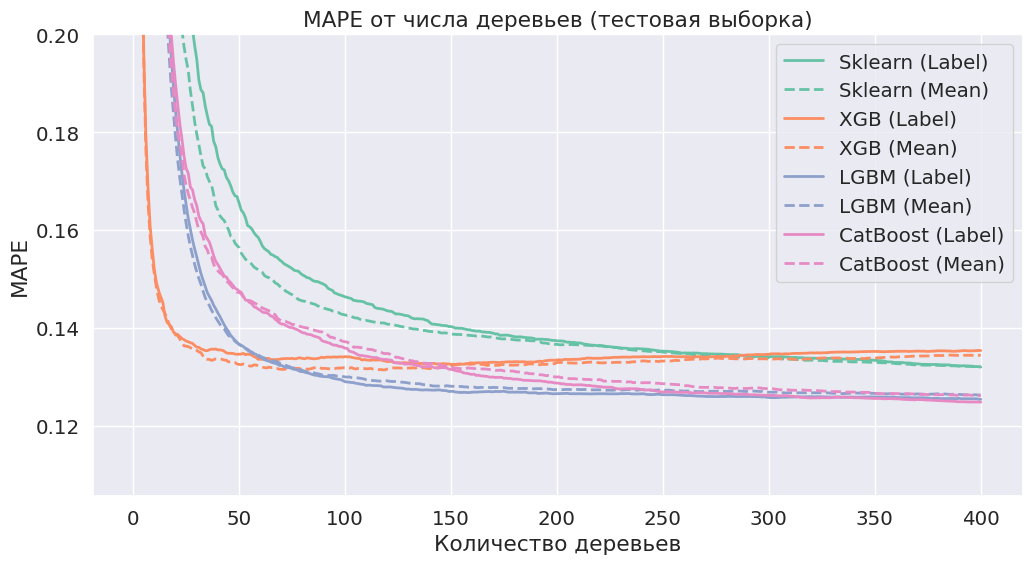

In [10]:
plot_dependence_test(
    param_grid, [test_values_list_label, test_values_list_mean], 
    'Количество деревьев', 'MAPE', 
    'MAPE от числа деревьев (тестовая выборка)',
    model_names, ylim=(None, 0.2), 
    linestyles=['-', '--']
)

Теперь будем обучать модели по глубине дерева:

In [27]:
models = [
    GradientBoostingRegressor()
]

model_names = ['Sklearn']

max_depth_values = np.arange(1, 21)

test_values_list_label = []
test_values_list_mean = []

# LabelEncoding
for model in tqdm(models):
    param_grid, test_values = train_and_plot_dependence(
        model, X_train_labeled, y_train, X_test_labeled, y_test,
        param_name='max_depth', param_grid=max_depth_values
    )
    test_values_list_label.append(test_values)
    clear_output()

# MeanEncoding
for model in tqdm(models):
    param_grid, test_values = train_and_plot_dependence(
        model, X_train_meaned, y_train, X_test_meaned, y_test,
        param_name='max_depth', param_grid=max_depth_values
    )
    test_values_list_mean.append(test_values)
    clear_output()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:41<00:00, 221.01s/it]


И график

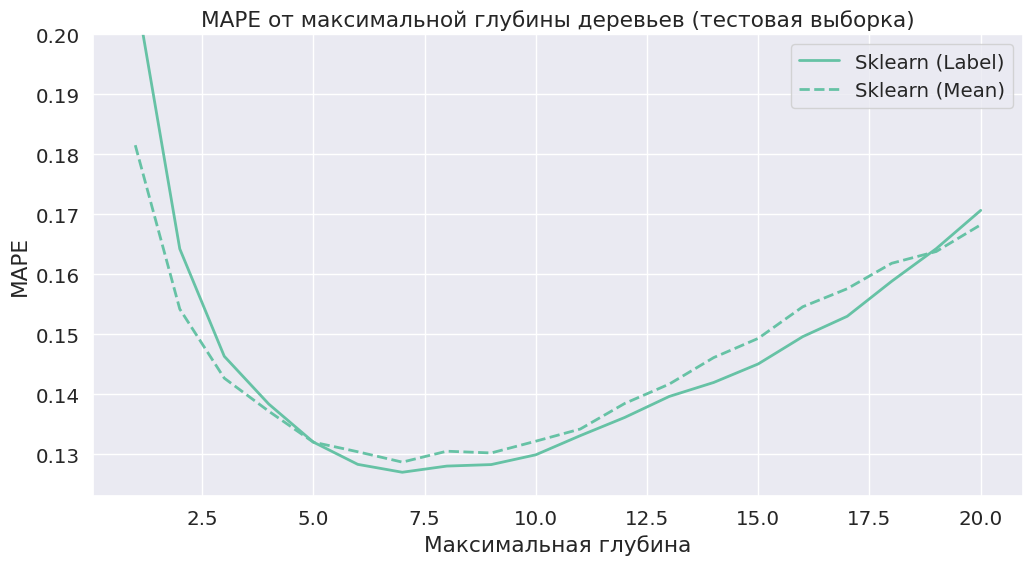

In [28]:
plot_dependence_test(
    param_grid, [test_values_list_label, test_values_list_mean], 
    'Максимальная глубина', 'MAPE', 
    'MAPE от максимальной глубины деревьев (тестовая выборка)',
    model_names, ylim=(None, 0.2), 
    linestyles=['-', '--']
)

**Выводы:**

Если в лоб все категориальные признаки закодировать ровно одним способом - то сильного выигрыша не получится, и это верно для более широкого класса моделей, чем градиентного бустинга из sklearn. 

Для градиентного бустинга из sklearn Mean усилила скорость схождения (требуется меньше деревьев для той же точности); чуть выше точность на менее глубоких деревьях, а на более глубоких - наоборот;

На практике следует аккруратно подбирать кодировку для каждого из признаков. Label подойдет больше для порядковых категорий, а Mean - для более широкого класса категорий.